# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from simfaas.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=1e6)
sim.generate_trace(debug_print=False, progress=True)
sim.print_trace_results()

100%|██████████| 1000000/1000000 [00:44<00:00, 22269.37it/s]
Cold Starts / total requests: 	 1221 / 900124
Cold Start Probability: 	 0.0014
Rejection / total requests: 	 0 / 900124
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 6307.7389
Average Server Count:  		 7.6795
Average Running Count:  	 1.7902
Average Idle Count:  		 5.8893


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [3]:
sim.calculate_time_lengths()
skip_init = sim.get_skip_init(skip_init_time=100)

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_index=skip_init)
sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_index=skip_init)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

Value           Prob
(6, 'u')        0.0003
(6, 'd')        0.0587
(11, 'u')       0.0066
(11, 'd')       0.0000
(9, 'u')        0.1282
(9, 'd')        0.0024
(8, 'u')        0.3177
(8, 'd')        0.0465
(7, 'd')        0.2771
(12, 'u')       0.0018
(10, 'd')       0.0000
(10, 'u')       0.0259
(7, 'u')        0.1347


,state,prob,sojourn_time
1,"(6, d)",0.058735,202.515168
0,"(6, u)",0.000332,331.897023
8,"(7, d)",0.277073,464.351940
12,"(7, u)",0.134687,462.794599
7,"(8, d)",0.046452,182.147013
6,"(8, u)",0.317693,532.989181
5,"(9, d)",0.002446,43.681111
4,"(9, u)",0.128246,502.876056
10,"(10, d)",0.000017,1.233508
11,"(10, u)",0.025902,462.493837


## Calculate Average Transition Times

In [4]:
residence_times, transition_times = sim.analyze_custom_states(hist_states, skip_init_index=skip_init)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
5,"(6, d)","(7, u)",290,202.515168,290,1.000000
0,"(6, u)","(7, u)",1,331.897023,1,1.000000
3,"(7, d)","(8, u)",340,503.658139,595,0.571429
4,"(7, d)","(6, d)",255,411.943675,595,0.428571
1,"(7, u)","(8, u)",256,390.919241,291,0.879725
13,"(7, u)","(6, d)",35,988.511506,291,0.120275
8,"(8, d)","(7, d)",239,172.731469,255,0.937255
12,"(8, d)","(9, u)",16,322.791707,255,0.062745
2,"(8, u)","(7, d)",357,774.731297,596,0.598993
6,"(8, u)","(9, u)",239,171.893217,596,0.401007


## Calculate Transition Time Histograms

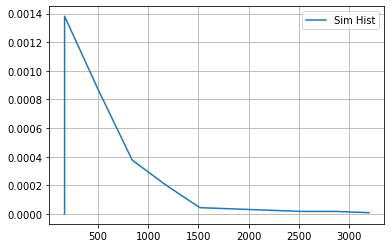

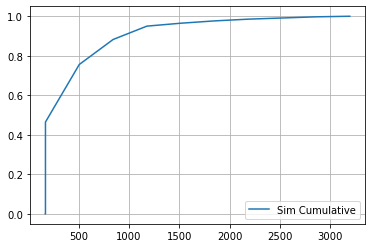

In [5]:
from simfaas.Utility import convert_hist_pdf

transition = ((7, 'd'),(8, 'u'))
traces = transition_times[transition]
num_bins = 10
base, hist_values, cumulative = convert_hist_pdf(traces, num_bins)

plt.figure()
plt.plot(base, hist_values, label='Sim Hist')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(base, cumulative, label='Sim Cumulative')
plt.legend()
plt.grid(True)

## Calculate Cold Start Probabily per State

In this section, we want to calculate the probability of a cold start occuring for a given state. This gives us a lot of insight about how to debug our performance model.

In [6]:
reqdf = sim.get_request_custom_states(hist_states=hist_states, skip_init_index=skip_init)
reqdf = reqdf.sort_values(by='state')
reqdf

,state,cold,warm,rej,total,p_cold
4,"(6, d)",290,52806,0,53096,0.005462
0,"(6, u)",1,325,0,326,0.003067
3,"(7, d)",340,248581,0,248921,0.001366
1,"(7, u)",256,121101,0,121357,0.002109
6,"(8, d)",16,41851,0,41867,0.000382
2,"(8, u)",239,286061,0,286300,0.000835
8,"(9, d)",0,2182,0,2182,0.000000
5,"(9, u)",56,114966,0,115022,0.000487
10,"(10, d)",0,7,0,7,0.000000
7,"(10, u)",14,23210,0,23224,0.000603


## Calculate Time Average of Server Count

Value           Prob
6               0.0591
7               0.4118
8               0.3641
9               0.1307
10              0.0259
11              0.0066
12              0.0018


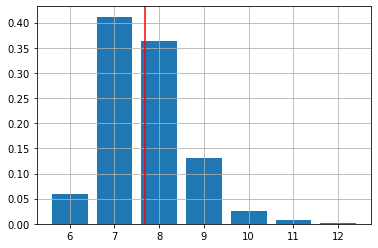

In [7]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [8]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,6,0.059067
1,7,0.411759
2,8,0.364145
3,9,0.130693
4,10,0.025920
5,11,0.006614
6,12,0.001802
